# Fake News Classification

# 📑 Project Plan: Fake News Detection with PyTorch (WELFake Dataset)

## 1. Data Preparation
- Download the dataset (**WELFake from Kaggle**).  
- Perform **EDA (Exploratory Data Analysis)**:
  - Check dataset size, number of fake vs. real articles.  
  - Look at average text length (titles vs. articles).  
- Preprocess text:
  - Lowercasing.  
  - Remove punctuation, numbers, HTML tags.  
  - Optional: remove stopwords.  
- Merge `title + text` into a single input column.  

---

## 2. Tokenization & Vocabulary
- Build a vocabulary (`word2idx`) from the dataset.  
- Limit vocab size (e.g., top 50k words).  
- Tokenize and pad/truncate sequences to a fixed length (e.g., 200–300 tokens).  

---

## 3. Dataset & DataLoader
- Implement a custom PyTorch `Dataset` class returning `(input_ids, label)`.  
- Use `torch.utils.data.DataLoader` to batch and shuffle data.  
- Split into **train/validation/test** sets.  

---

## 4. Model Architecture (Custom PyTorch)
Possible architectures:  

1. **Baseline LSTM**  
   - `Embedding → LSTM → Fully Connected → Sigmoid`.  

2. **BiLSTM + Attention**  
   - Stronger model, captures word order and importance.  

3. **CNN for Text**  
   - Faster to train, good for short texts.  

---

## 5. Training Loop
- Loss function: `nn.BCEWithLogitsLoss()`.  
- Optimizer: Adam (learning rate ~1e-3).  
- Use GPU if available (`model.to(device)`).  
- Training loop:
  1. Forward pass.  
  2. Compute loss.  
  3. Backward pass (`loss.backward()`).  
  4. Update weights (`optimizer.step()`).  

---

## 6. Evaluation
- Metrics: **Accuracy, Precision, Recall, F1-score, ROC-AUC**.  
- Plot **confusion matrix**.  
- Compare validation vs. training loss/accuracy to detect overfitting.  

---

## 7. Advanced Improvements
- Add **Dropout** and **regularization** to reduce overfitting.  
- Use **Bidirectional LSTM**.  
- Experiment with **pre-trained embeddings** (e.g., GloVe, FastText).  
- Add an **Attention layer** to highlight important words.  
- Try **hyperparameter tuning**: embedding size, hidden size, learning rate, etc.  

---

## 8. (Optional) Benchmark with Transformers
- After building your own PyTorch models, compare them with a fine-tuned **BERT (via Hugging Face)**.  
- This shows the performance gap between a hand-built model and a state-of-the-art transformer.  

---

## ✅ Final Deliverables
1. Classical ML baseline (**TF-IDF + Logistic Regression**).  
2. Custom PyTorch model (**LSTM/GRU/CNN**).  
3. Advanced benchmark (**BERT fine-tuning**).  


## 1. Data Preparation

In [33]:
import pandas as pd

df = pd.read_csv("WELFake_Dataset.csv")

df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [34]:
print(f"Dataset has {df.shape[0]} rows and {df.shape[1]} columns")

Dataset has 72134 rows and 4 columns


In [35]:
columns_info = pd.DataFrame({
    "Columns" : df.columns,
    "DataType" : df.dtypes.values,
    'MissingValues' : df.isnull().sum().values
})
columns_info

,Columns,DataType,MissingValues
0,Unnamed: 0,int64,0
1,title,object,558
2,text,object,39
3,label,int64,0


#### Delete rows without text

In [36]:
df = df.dropna(subset=["text"])


In [37]:
true_news_count = len(df[df['label'] == 1])
fake_news_count = len(df[df['label'] == 0])
print(f"Fake news quantity: {fake_news_count}")
print(f"True news quantity {true_news_count}")

Fake news quantity: 35028
True news quantity 37067


In [38]:
df['len_title'] = df['title'].fillna("").apply(len)
df['len_text'] = df['text'].fillna("").apply(len)
df

,Unnamed: 0,title,text,label,len_title,len_text
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,130,5049
1,1,NaN,Did they post their votes for Hillary already?,1,0,46
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,137,216
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,105,8010
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,95,1916
...,...,...,...,...,...,...
72129,72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0,65,4788
72130,72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1,79,3634
72131,72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0,57,2864
72132,72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0,67,3374


In [39]:
print(f"Average len of title: {int(df.len_title.mean())}")
print(f"Average len of text: {int(df.len_text.mean())}")

Average len of title: 76
Average len of text: 3270


In [42]:
import re

def clean_text(text):
    if not isinstance(text, str):  # если NaN или не строка
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_title'] = df['title'].apply(clean_text)
df['clean_text'] = df['text'].apply(clean_text)
df

,Unnamed: 0,title,text,label,len_title,len_text,clean_title,clean_text
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,130,5049,law enforcement on high alert following threat...,no comment is expected from barack obama membe...
1,1,NaN,Did they post their votes for Hillary already?,1,0,46,,did they post their votes for hillary already
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,137,216,unbelievable obama s attorney general says mos...,now most of the demonstrators gathered last ni...
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,105,8010,bobby jindal raised hindu uses story of christ...,a dozen politically active pastors came here f...
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,95,1916,satan 2 russia unvelis an image of its terrify...,the rs 28 sarmat missile dubbed satan 2 will r...
...,...,...,...,...,...,...,...,...
72129,72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0,65,4788,russians steal research on trump in hack of u ...,washington reuters hackers believed to be work...
72130,72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1,79,3634,watch giuliani demands that democrats apologiz...,you know because in fantasyland republicans ne...
72131,72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0,57,2864,migrants refuse to leave train at refugee camp...,migrants refuse to leave train at refugee camp...
72132,72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0,67,3374,trump tussle gives unpopular mexican leader mu...,mexico city reuters donald trump s combative s...


In [44]:
df['title_text'] = df['clean_title'] + " " + df['clean_text']

<Axes: >

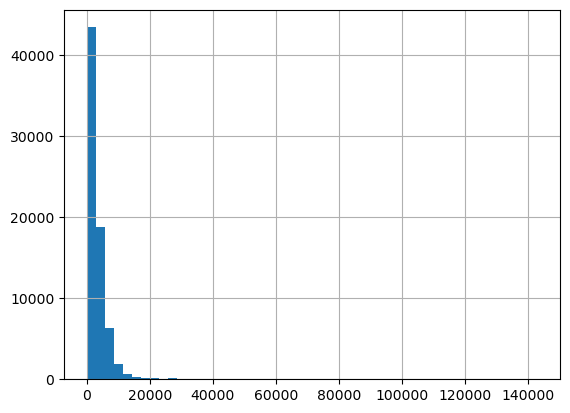

In [45]:
df['len_text'].hist(bins=50)


## 2. Tokenization & Vocabulary


In [64]:
from collections import Counter

all_words = " ".join(df['title_text']).split()

word_counts = Counter(all_words)
print(f"Counts unique words: {len(word_counts)}")

Counts unique words: 214572


In [66]:
vocab_size = 50000
most_common = word_counts.most_common(vocab_size - 2)


In [67]:
word2idx = {"<PAD>": 0, "<UNK>": 1}
for i, (word, _) in enumerate(most_common, start=2):
    word2idx[word] = i

print("Dict size:", len(word2idx))
print("Example:", list(word2idx.items())[:20])


Dict size: 50000
Example: [('<PAD>', 0), ('<UNK>', 1), ('the', 2), ('to', 3), ('of', 4), ('and', 5), ('a', 6), ('in', 7), ('s', 8), ('that', 9), ('is', 10), ('for', 11), ('on', 12), ('it', 13), ('he', 14), ('with', 15), ('was', 16), ('as', 17), ('said', 18), ('trump', 19)]


In [68]:
sample = "fake news is here".split()
encoded = [word2idx.get(word, 1) for word in sample]  # 1 = <UNK>
print(encoded)


[870, 103, 10, 138]


In [69]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

filtered_words = [word for word in all_words if word not in stop_words]
word_counts_nostop = Counter(filtered_words)

most_common_nostop = word_counts_nostop.most_common(vocab_size - 2)
word2idx_nostop = {"<PAD>": 0, "<UNK>": 1}
for i, (word, _) in enumerate(most_common_nostop, start=2):
    word2idx_nostop[word] = i


[nltk_data] Downloading package stopwords to /Users/danil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [70]:
def text_to_sequence(text, word2idx, max_len=300):
    tokens = text.split() 
    seq = [word2idx.get(word, 1) for word in tokens]  
    
    if len(seq) < max_len:
        seq = seq + [0] * (max_len - len(seq))  
    else:
        seq = seq[:max_len]
    
    return seq


In [71]:
max_len = 300 
df['sequence'] = df['title_text'].apply(lambda x: text_to_sequence(x, word2idx, max_len))


In [72]:
print(df['sequence'].iloc[0][:50])
print(len(df['sequence'].iloc[0])) 


[149, 726, 12, 304, 4120, 528, 1336, 98, 2455, 5, 3122, 12, 543, 1, 9675, 5, 1, 1093, 176, 66, 518, 10, 575, 29, 538, 78, 273, 4, 2, 1, 43, 1, 5, 9675, 3667, 173, 11, 2, 15634, 5, 5128, 4, 105, 47, 5, 2455, 31, 3289, 392, 12]
300
